In [1]:
import robobo
import pandas as pd
import torch
import time
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical, Normal
from tqdm import tqdm
import numpy as np
from collections import deque

Hardware Connection not available in python3 :(


In [2]:
class Environment(robobo.SimulationRobobo):
    def __init__(self,
                 sim_time_s,
                 act_granularity_s
                 ):
        super().__init__()
        super().connect('192.168.1.133', 19997)
        self.attempts = 0
        self.sim_time = sim_time_s * 1000.
        self.initiated = False
        self.fps = 1000 / act_granularity_s
        self.act_granularity = act_granularity_s * 1000
    def start_sim(self): return self.play_simulation()
    def end_sim(self): return self.stop_world()
    def dc(self): return self.disconnect()
    def pause_sim(self): return self.pause_simulation()
    def reset(self):
        try:
            if self.is_simulation_running():
                self.end_sim()
                self.start_sim()
            else:
                self.start_sim()
            time.sleep(3)
            return self.get_state()
        except:
            print(f"Fail - Attempt {self.attempts}")
            self.attempts += 1
            self.disconnect()
            self.connect('192.168.1.133', 19997)
            self.reset()
    def get_state(self):
        #todo do in parent class
        X1 = np.array([[ .2 if not _ else _ for _ in env.read_irs() ]])
        X1 = (X1 - 0.) / (.2 - 0.) 
        X1 = 1 - X1 
        X1[0,:3] = X1[0,:3] * 1.67
        return X1
    def step(self, action, discrete=False,act_factor=.1):
        if not discrete:
            action = action[0] * 100 * act_factor
        else:
            action = {0:(20,20) , 1:(-20,-20)}[action]
        self.move(action[0], action[1], self.act_granularity)
        new_state = self.get_state()
        sensors = np.exp(new_state.sum())
        rot = np.abs(action[0] - action[1])
        reward = -(sensors + np.sqrt(rot))
        
        #reward = action.sum() * (1 - rot/200)  * (1 - new_state.max())
        done = True if self.get_sim_time() > self.sim_time else False
        return new_state, reward, done

            

In [3]:
#discount factor for future utilities
DISCOUNT_FACTOR = 1
ACTION_SPACE = 2
OBSERVATION_SPACE = 8
#number of episodes to run
NUM_EPISODES = 10
# duration of actuators in s
ACT_GRANULARITY = .5
#max steps per episode
MAX_STEPS = 1000
#max sim time in s
MAX_SIM_TIME = 60 * 10
# limit variance
LOG_SIG_MAX = 2
LOG_SIG_MIN = -20
#device to run model on 
DEVICE = "cpu"

In [5]:
#Using a neural network to learn our policy parameters
class PolicyNetwork0(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer = nn.Linear(observation_space, 32)
        self.mu = nn.Linear(32, action_space)
        self.log_std = nn.Linear(32, action_space)
    
    #forward pass
    def forward(self, x):
        #input states
        x = self.input_layer(x)
        #relu activation
        x = F.relu(x)
        #actions
        mu = self.mu(x)
        log_std = self.log_std(x)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        std = log_std.exp()
        
        return mu, std
    
#Using a neural network to learn our policy parameters
class PolicyNetwork(nn.Module):
    
    #Takes in observations and outputs actions
    def __init__(self, observation_space, action_space):
        super(PolicyNetwork, self).__init__()
        self.input_layer1 = nn.Linear(observation_space, 32)
        self.input_layer2 = nn.Linear(32, 32)
        self.input_layer3 = nn.Linear(32, 32)
        self.input_layer4 = nn.Linear(32, 32)
        self.mu = nn.Linear(32, action_space)
        self.log_std = nn.Linear(32, action_space)
    
    #forward pass
    def forward(self, x):
        #input states
        y = self.input_layer1(x)
        y = F.relu(y)
        
        z = self.input_layer2(y)
        z = z + y
        z = F.relu(z)
        
        k = self.input_layer3(z)
        k = k + z
        k = F.relu(k)
        
        j = self.input_layer4(k)
        j = j + k
        j = F.relu(j)

        #actions
        mu = self.mu(j)
        log_std = self.log_std(j)
        log_std = torch.clamp(log_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        std = log_std.exp()
        
        return mu, std

In [6]:
#Using a neural network to learn state value
class StateValueNetwork(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        
        self.input_layer1 = nn.Linear(observation_space, 32)
        self.input_layer2 = nn.Linear(32, 32)
        self.input_layer3 = nn.Linear(32, 32)
        self.input_layer4 = nn.Linear(32, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        #input states
        y = self.input_layer1(x)
        y = F.relu(y)
        
        z = self.input_layer2(y)
        z = z + y
        z = F.relu(z)
        
        k = self.input_layer3(z)
        k = k + z
        k = F.relu(k)
        
        j = self.input_layer4(k)
        j = j + k
        j = F.relu(j)
        
        #get state value
        state_value = self.output_layer(j)
        
        return state_value

#Using a neural network to learn state value
class StateValueNetwork0(nn.Module):
    
    #Takes in state
    def __init__(self, observation_space):
        super(StateValueNetwork, self).__init__()
        
        self.input_layer = nn.Linear(observation_space, 32)
        self.output_layer = nn.Linear(32, 1)
        
    def forward(self, x):
        #input layer
        x = self.input_layer(x)
        
        #activiation relu
        x = F.relu(x)
        
        #get state value
        state_value = self.output_layer(x)
        
        return state_value

In [7]:
def select_action(network, state):
    ''' Selects an action given current state
    Args:
    - network (Torch NN): network to process state
    - state (Array): Array of action space in an environment
    
    Return:'
    - (int): action that is selected
    - (float): log probability of selecting that action given state and network
    '''
    
    #convert state to float tensor, add 1 dimension, allocate tensor on device
    state = torch.from_numpy(state).float().to(DEVICE)
    
    #use network to predict action probabilities
    mu, std = network(state)
    state = state.detach()
    
    #sample an action using the probability distribution
    m = Normal(mu, std)
    action = m.sample()
    
    #return action
    return action.numpy(), m.log_prob(action)

In [8]:
# Init environment
env = Environment(MAX_SIM_TIME, ACT_GRANULARITY)
#Init network
policy_network = PolicyNetwork(OBSERVATION_SPACE, ACTION_SPACE).to(DEVICE)
stateval_network = StateValueNetwork(OBSERVATION_SPACE).to(DEVICE)

#Init optimizer
policy_optimizer = optim.Adam(policy_network.parameters(), lr=0.0001)
stateval_optimizer = optim.Adam(stateval_network.parameters(), lr=0.0001)

Connected to remote API server: client id 0


  0%|                                                    | 0/10 [00:00<?, ?it/s]

Fail - Attempt 0
Connected to remote API server: client id 0


/tmp/ipykernel_582321/3384480549.py:51: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.smooth_l1_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
 10%|████▎                                      | 1/10 [03:12<28:49, 192.19s/it]/tmp/ipykernel_582321/3384480549.py:51: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.smooth_l1_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
 20%|████████▌                                  | 2/10 [06:15<24:55, 186.96s/it]/tmp/ipykernel_582321/3384480549.py:51: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead

Fail - Attempt 1
Connected to remote API server: client id 0


/tmp/ipykernel_582321/3384480549.py:51: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  val_loss = F.smooth_l1_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
100%|████████████████████████████████████████| 10/10 [1:27:22<00:00, 524.25s/it]


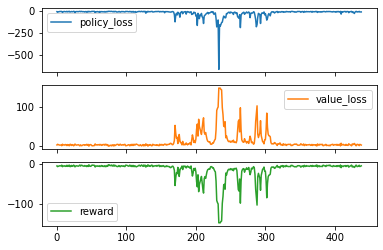

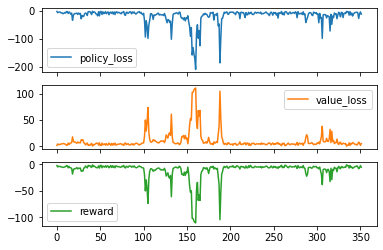

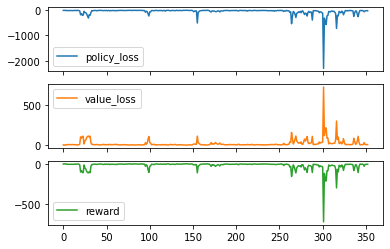

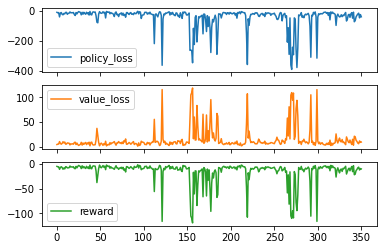

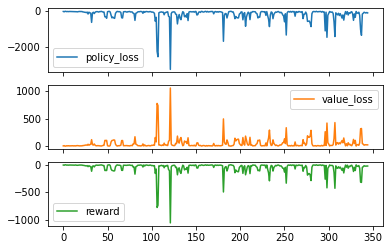

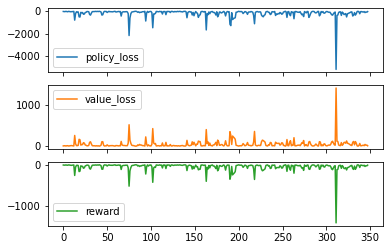

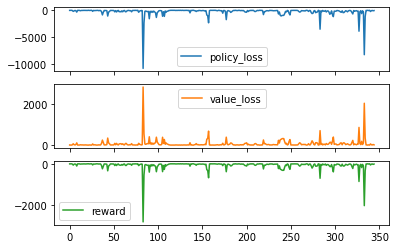

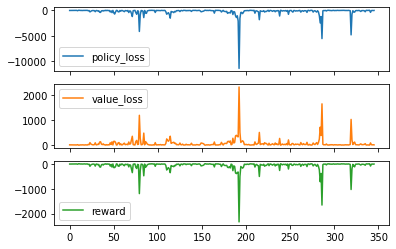

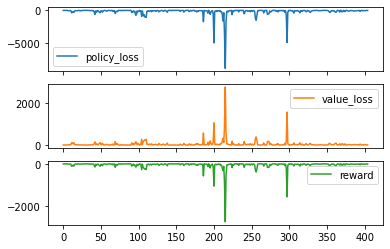

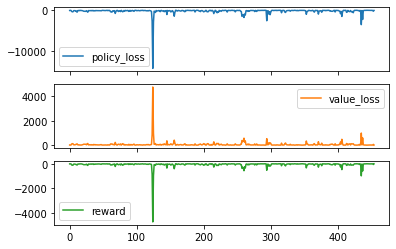

In [9]:
#track scores
scores = []
episodes = dict()

#run episodes
for episode in tqdm(range(NUM_EPISODES)):
    episodes[episode] = dict()
    episodes[episode]["policy_loss"] = []
    episodes[episode]["value_loss"] = []
    episodes[episode]["reward"] = []
    episodes[episode]["states"] = []
    episodes[episode]["actions"] = []
    episodes[episode]["next_state"] = []
    episodes[episode]["grad_policy_mu"] = []
    episodes[episode]["grad_policy_std"] = []
    episodes[episode]["grad_value"] = []
    #init variables
    state = env.reset()
    if state is None:
        state = env.get_state()
    done = False
    score = 0
    I = 1
    
    #run episode, update online
    while 1+1 == 2:
        
        #get action and log probability
        action, lp = select_action(policy_network, state)

        #step with action
        new_state, reward, done = env.step(action)

        #update episode score
        score += reward

        #get state value of current state
        state_tensor = torch.from_numpy(state).float().to(DEVICE)
        state_val = stateval_network(state_tensor)

        #get state value of next state
        new_state_tensor = torch.from_numpy(new_state).float().to(DEVICE)  
        new_state_val = stateval_network(new_state_tensor)

        #if terminal state, next state val is 0
        if done:
            new_state_val = torch.tensor([0]).float().to(DEVICE)

        #calculate value function loss with MSE
        #val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss = F.smooth_l1_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
        val_loss *= I

        #calculate policy loss
        advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
        policy_loss = -lp.mean() * advantage
        policy_loss *= I

        #Backpropagate policy
        policy_optimizer.zero_grad()
        policy_loss.backward(retain_graph=True)
        nn.utils.clip_grad_norm_([p for g in policy_optimizer.param_groups for p in g["params"]], .5) 
        policy_optimizer.step()

        #Backpropagate value
        stateval_optimizer.zero_grad()
        val_loss.backward(retain_graph=False)
        stateval_optimizer.step()

        if done:
            break
    
        episodes[episode]["policy_loss"] += [policy_loss.item()]
        episodes[episode]["value_loss"] += [val_loss.item()]
        episodes[episode]["reward"] += [reward.item()]
        episodes[episode]["states"] += [state]
        episodes[episode]["actions"] += [action]
        episodes[episode]["next_state"] += [new_state]
        episodes[episode]["grad_policy_mu"] += [policy_network.mu.weight.grad.sum()]
        episodes[episode]["grad_policy_std"] += [policy_network.log_std.weight.grad.sum()]
        episodes[episode]["grad_value"] += [stateval_network.output_layer.weight.grad.sum()]
        #move into new state, discount I
        state = new_state
        I *= DISCOUNT_FACTOR
    pd.DataFrame(episodes[episode])[['policy_loss', 'value_loss', 'reward']].plot(subplots=True)

<AxesSubplot:>

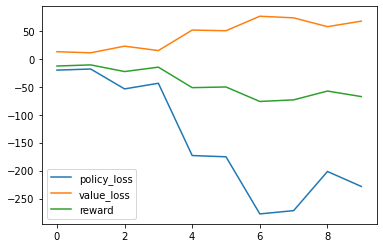

In [10]:
res = pd.DataFrame(
    [pd.DataFrame(episodes[episode])[['policy_loss', 'value_loss', 'reward']].mean() for episode in episodes])
res.plot()

In [24]:
#env.move(20,0,500)
env.move(0,0,500)

In [18]:
#init variables
state = env.reset()
if state is None:
    state = env.get_state()
done = False
score = 0
I = 1
pls, vls, rws = [], [], []

In [19]:
#init variables
state = env.reset()
if state is None:
    state = env.get_state()
done = False
score = 0
I = 1
pls, vls, rws = [], [], []

for i in range(100):
    #get action and log probability
    action, lp = select_action(policy_network, state)

    #step with action
    new_state, reward, done = env.step(action)

    #update episode score
    score += reward

    #get state value of current state
    state_tensor = torch.from_numpy(state).float().to(DEVICE)
    state_val = stateval_network(state_tensor)

    #get state value of next state
    new_state_tensor = torch.from_numpy(new_state).float().to(DEVICE)  
    new_state_val = stateval_network(new_state_tensor)

    #if terminal state, next state val is 0
    if done:
        new_state_val = torch.tensor([0]).float().to(DEVICE)

    #calculate value function loss with MSE
    #val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
    val_loss = F.smooth_l1_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
    val_loss *= I

    #calculate policy loss
    advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
    policy_loss = -lp.mean() * advantage
    policy_loss *= I

    #Backpropagate policy
    policy_optimizer.zero_grad()
    policy_loss.backward(retain_graph=True)
    nn.utils.clip_grad_norm_([p for g in policy_optimizer.param_groups for p in g["params"]], .5) 
    policy_optimizer.step()

    #Backpropagate value
    stateval_optimizer.zero_grad()
    val_loss.backward(retain_graph=False)
    stateval_optimizer.step()


    #move into new state, discount I
    state = new_state
    I *= DISCOUNT_FACTOR
    #print(reward.item(), action)
    pls.append(policy_loss.item())
    vls.append(val_loss.item())
    rws.append(reward.item())
    print("policy_mu : ", policy_network.mu.weight.grad.sum())
    print("policy_log_std : ", policy_network.log_std.weight.grad.sum())
    print("value  : ", stateval_network.output_layer.weight.grad.sum())

policy_mu :  tensor(0.0718)
policy_log_std :  tensor(-1.3465)
value  :  tensor(0.5580)
policy_mu :  tensor(-1.2757)
policy_log_std :  tensor(-0.8026)
value  :  tensor(1.0243)
policy_mu :  tensor(0.0596)
policy_log_std :  tensor(-0.9446)
value  :  tensor(0.4482)
policy_mu :  tensor(0.4120)
policy_log_std :  tensor(-1.3879)
value  :  tensor(0.3884)
policy_mu :  tensor(0.6209)
policy_log_std :  tensor(0.5941)
value  :  tensor(-0.1892)
policy_mu :  tensor(-0.6926)
policy_log_std :  tensor(-1.6742)
value  :  tensor(-0.0165)
policy_mu :  tensor(0.5723)
policy_log_std :  tensor(0.8235)
value  :  tensor(-0.5610)
policy_mu :  tensor(0.9712)
policy_log_std :  tensor(-1.6030)
value  :  tensor(-0.5784)
policy_mu :  tensor(0.6498)
policy_log_std :  tensor(-0.9750)
value  :  tensor(0.3987)
policy_mu :  tensor(0.3564)
policy_log_std :  tensor(-1.5209)
value  :  tensor(-0.0327)
policy_mu :  tensor(-1.9060)
policy_log_std :  tensor(-0.1464)
value  :  tensor(0.4536)
policy_mu :  tensor(-0.5791)
policy_l

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

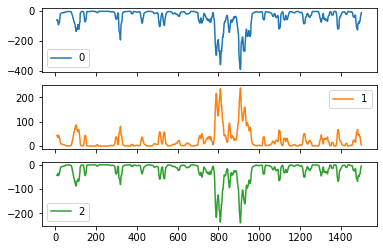

In [17]:
pd.DataFrame([pls, vls, rws]).T.rolling(10).mean().plot(subplots=True)

<AxesSubplot:>

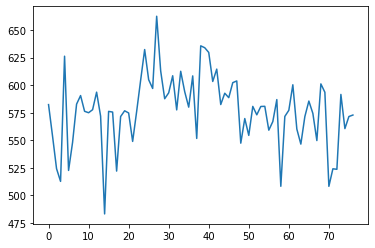

In [15]:
pd.Series(scores).plot()

In [ ]:
#init variables
state = env.reset()
if state is None:
    state = env.get_state()
done = False
score = 0
I = 1
pls, vls, rws = [], [], []

In [ ]:

#run episode, update online
#get action and log probability
action, lp = select_action(policy_network, state)

#step with action
new_state, reward, done = env.step(action)

#update episode score
score += reward

#get state value of current state
state_tensor = torch.from_numpy(state).float().unsqueeze(0).to(DEVICE)
state_val = stateval_network(state_tensor)

#get state value of next state
new_state_tensor = torch.from_numpy(new_state).float().unsqueeze(0).to(DEVICE)        
new_state_val = stateval_network(new_state_tensor)

#if terminal state, next state val is 0
if done:
    new_state_val = torch.tensor([0]).float().unsqueeze(0).to(DEVICE)

#calculate value function loss with MSE
val_loss = F.mse_loss(reward + DISCOUNT_FACTOR * new_state_val, state_val)
val_loss *= I

#calculate policy loss
advantage = reward + DISCOUNT_FACTOR * new_state_val.item() - state_val.item()
policy_loss = -lp * advantage
policy_loss *= I

#Backpropagate policy
policy_optimizer.zero_grad()
policy_loss.backward(retain_graph=True)
policy_optimizer.step()

#Backpropagate value
stateval_optimizer.zero_grad()
val_loss.backward()
stateval_optimizer.step()

if done:
    break

#move into new state, discount I
state = new_state
I *= DISCOUNT_FACTOR

pls.append(policy_loss.item())
vls.append(val_loss.item())
rws.append(reward.item())